In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import os, json
import pandas as pd
import numpy as np
import seaborn as sns
import math

def get_ranking_representations_in_order(dict):
    ranking_data = dict["ranking"]
    task_order = dict["treatmentOrder"]
    rankings_per_task = []
    for i in range(0,len(ranking_data)):
        if ranking_data[i]["category"] == "rankingRepresentation":
            rankings_per_task.append(ranking_data[i]["ranking"])
    sorted_rankings_by_task = [0] * 3;
    sorted_rankings_by_task[task_order[0]] = rankings_per_task[0]
    sorted_rankings_by_task[task_order[1]] = rankings_per_task[1]
    sorted_rankings_by_task[task_order[2]] = rankings_per_task[2]
    return sorted_rankings_by_task

def get_task_actions_in_order(dict):
    ranking_data = dict["ranking"]
    task_order = dict["treatmentOrder"]
    actions_per_task = []
    for i in range(0,len(ranking_data)):
        if ranking_data[i]["category"] == "rankingRepresentation":
            actions = []
            for j in range(i+1,len(ranking_data)):
                if ranking_data[j]["category"] == "serverEvent" or ranking_data[j]["category"] == "timeStamps":
                    i = j
                    break
                actions.append(ranking_data[j])
            actions_per_task.append(actions)
    sorted_actions_by_task = [0] * 3;
    sorted_actions_by_task[task_order[0]] = actions_per_task[0]
    sorted_actions_by_task[task_order[1]] = actions_per_task[1]
    sorted_actions_by_task[task_order[2]] = actions_per_task[2]
    return sorted_actions_by_task
        
def filter_for_choices(actions, ranking):
    selected_ids = []
    for action in actions:
        if action["eventName"] == "select":
            selected_ids.append(action["itemID"])
        if action["eventName"] == "unselect":
            selected_ids.remove(action["itemID"])
        if action["eventName"] == "fourthElementSelected":
            selected_ids.remove(action["itemID"])
    choices = []
    for id in selected_ids:
        for cand in ranking:
            try:
                if id == cand["id"]:
                    choices.append(cand)
            except:
                if id == cand[0]["id"]:
                    choices.append(cand[0])
                if id == cand[1]["id"]:
                    choices.append(cand[1])
    return choices

def get_survey_answers(dict):
    survey = dict["survey"]
    answers = []
    for entry in survey:
        if entry["category"] == "surveyQuestionAnswers":
            answers.append(entry)
    return answers

def load_data_as_df(path):
    path_to_jsonfiles = path
    cols = ['uID', 'ranking_type','briefing','task_order','task_1_ranking', 'task_2_ranking', 'task_3_ranking',
               'task_1_actions','task_2_actions','task_3_actions','task_1_choices','task_2_choices',
            'task_3_choices','survey_answers']
    data = pd.DataFrame(columns=cols)
    for file in os.listdir(path_to_jsonfiles):
        full_filename = "%s/%s" % (path_to_jsonfiles, file)
        with open(full_filename,'r') as fi:
            dict = json.load(fi)
            uID = file[0:len(file)-5]
            ranking_type = int(dict["ranking"][0]["itemID"])
            briefing = dict["briefing"]
            task_order = dict["treatmentOrder"]
            task_rankings = get_ranking_representations_in_order(dict)
            task_1_ranking = task_rankings[0]
            task_2_ranking = task_rankings[1]
            task_3_ranking = task_rankings[2]
            task_actions = get_task_actions_in_order(dict)
            task_1_actions = task_actions[0]
            task_2_actions = task_actions[1]
            task_3_actions = task_actions[2]
            task_1_choices = filter_for_choices(task_1_actions, task_1_ranking)
            task_2_choices = filter_for_choices(task_2_actions, task_2_ranking)
            task_3_choices = filter_for_choices(task_3_actions, task_3_ranking)
            survey_answers = get_survey_answers(dict)
            
            data = data.append({'uID': uID, 'ranking_type': ranking_type, 'briefing': briefing, 'task_order': task_order,
                               'task_1_ranking': task_1_ranking, 'task_2_ranking': task_2_ranking, 'task_3_ranking': task_3_ranking,
                               'task_1_actions': task_1_actions, 'task_2_actions': task_2_actions, 'task_3_actions': task_3_actions,
                               'task_1_choices': task_1_choices, 'task_2_choices': task_2_choices, 'task_3_choices': task_3_choices,
                               'survey_answers': survey_answers}, ignore_index=True)
    return data

def write_selections_to_csv(first_n_choices, ranking_types, tasks, filename="", write=True):
    data = load_data_as_df('./final data')
    cols = ['id','rank','task_rabbit_score','positive_reviews','reliability','tasks_completed','isFemale','action']
    data = data[(data["ranking_type"].isin(ranking_types))] #ranking_types=[0,1,2,3,4,5]
    rows = []
    for i in range(0,len(data["ranking_type"])):
        seen = []
        representations = []
        selected = []
        if 0 in tasks:
            representations+=data.iloc[i][4]
            selected+=(data.iloc[i][10])[0:first_n_choices]
        if 1 in tasks:
            representations+=data.iloc[i][5]
            selected+=(data.iloc[i][11])[0:first_n_choices]
        if 2 in tasks:
            representations+=data.iloc[i][6]
            selected+=(data.iloc[i][12])[0:first_n_choices]
        for cand in representations:
            rank = cand["rank"]
            task_rabbit_score = cand["score"]
            positive_reviews = cand["tag1"]
            positive_reviews = positive_reviews[0:len(positive_reviews)-1]
            reliability = cand["tag2"]
            tasks_completed = cand["tag3"]
            if cand["gender"] == "m":
                isFemale = 0
            else:
                isFemale = 1
            cand_id = cand["id"]
            action = 0
            seen.append([cand_id,rank,task_rabbit_score,positive_reviews,reliability,tasks_completed,isFemale,action])
        for entry_sel in selected:
            for entry in seen:
                if entry[0] == entry_sel["id"]:
                    entry[7] = 1
        for l in seen:
            rows.append(l)
    df = pd.DataFrame(rows,columns=cols)
    df=df.drop(columns=['id'])
    dat = df
    if write:
        df.to_csv(filename, index=False)
    return dat

In [6]:
data = load_data_as_df('./Final Data s,m,e')
ranking_type_dist = [0,0,0,0,0,0]
for line in range(0,len(data.index)):
    ranking_type_dist[data.iloc[line, 1]]+=1
print(ranking_type_dist)

[16, 15, 15, 14, 15, 15]


In [64]:
def write_user_demographics_to_csv(first_n_choices, ranking_types, tasks, filename):
    data = load_data_as_df('./final data')
    

(30, 7)


In [70]:
data = load_data_as_df('./final data')
data.loc[0]
for i in range(0,len(data["survey_answers"])):
    choices_moving_assistance = data.loc[i][10]
    female_candidates_moving = 0
    
    choices_event_staffing = data.loc[i][11]
    female_candidates_event = 0
    
    choices_shopping = data.loc[i][12]
    female_candidates_shopping = 0
    
    for entry in choices_moving_assistance:
        if entry["gender"] == "f":
            female_candidates_moving+=1
    for entry in choices_event_staffing:
        if entry["gender"] == "f":
            female_candidates_event+=1
    for entry in choices_shopping:
        if entry["gender"] == "f":
            female_candidates_shopping+=1
    

'1601297577855A63078404'

In [15]:
write_selections_to_csv(4, [2,3], [0], filename ="taskRabbit_all_tasks_4_choices.csv")
write_selections_to_csv(3, [2,3], [0], filename ="taskRabbit_all_tasks_3_choices.csv")
write_selections_to_csv(2, [2,3], [0], filename ="taskRabbit_all_tasks_2_choices.csv")
write_selections_to_csv(1, [2,3], [0], filename ="taskRabbit_all_tasks_1_choices.csv")

write_selections_to_csv(4, [0], [0], filename ="random_all_tasks_4_choices.csv")
write_selections_to_csv(3, [0], [0], filename ="random_all_tasks_3_choices.csv")
write_selections_to_csv(2, [0], [0], filename ="random_all_tasks_2_choices.csv")
write_selections_to_csv(1, [0], [0], filename ="random_all_tasks_1_choices.csv")

write_selections_to_csv(4, [4], [0], filename ="fair_all_tasks_4_choices.csv")
write_selections_to_csv(3, [4], [0], filename ="fair_all_tasks_3_choices.csv")
write_selections_to_csv(2, [4], [0], filename ="fair_all_tasks_2_choices.csv")
write_selections_to_csv(1, [4], [0], filename ="fair_all_tasks_1_choices.csv")

,rank,task_rabbit_score,positive_reviews,reliability,tasks_completed,isFemale,action
0,1,0.868569,99,100,634,0,0
1,2,0.848492,100,100,41,1,0
2,3,0.859005,97,100,395,0,0
3,4,0.839492,100,100,141,1,0
4,5,0.850237,100,100,64,0,1
...,...,...,...,...,...,...,...
275,6,0.833916,99,100,7,1,0
276,7,0.848119,100,100,158,0,0
277,8,0.846683,98,100,388,0,0
278,9,0.838414,100,98,458,0,1


In [4]:
data = load_data_as_df('./Final Data s,m,e')
for i in range(0,len(data.index)):
    entry = data.loc[i]["survey_answers"]
    for q in entry:
        if q["question"] == 5:
            print(q["answers"])
            print('\n')
            #if q["answers"][0] == 'The selection process is aimed at finding and hiring the best candidates for job openings. ... Please try again later. ... Have the candidate describe in detail what actions they took to make the best ... We already briefly discussed assessments in the second step. ... The decision is best made based on a data-driven approach.\n':
                #print(data.loc[i])


["I favored people who had done the same kind of task many times before, so I know they had experience. I balanced this out with their positive review stats and their reliability. It wasn't easy as sometimes I had to choose someone with one criteria that was lower (number of previous tasks for example) because their other stats seemed great to me."]


["I tried to look mainly at experience and reviews to decide. Some of the algorithim'"]


["I tried to pick the candidates with the most tasks completed first and the highest percentage of reliability and positive reviews. I didn't try to take gender into account"]


['I based on how many previous tasks they completed and how reliable they are, the ratio goes hand in hand to me']


['Just made decisions based on experience and reviews']


['']


['academic background with good percentage and having high leadership quality.']


['I mostly looked at their reliability and percentage of positive reviews. That tells me alot about the type of w

In [14]:
print("Rabbit Ranking (M>W)")
data = write_selections_to_csv(4, [2], [0], write=False)
data = data[(data["isFemale"] == 1)]
data = data[(data["action"] == 1)]
selected_females_moving = data.shape[0]
data = write_selections_to_csv(4, [2], [0], write=False)
data = data[(data["isFemale"] == 0)]
data = data[(data["action"] == 1)]
selected_males_moving = data.shape[0]

data = write_selections_to_csv(4, [2], [1], write=False)
data = data[(data["isFemale"] == 1)]
data = data[(data["action"] == 1)]
selected_females_event = data.shape[0]
data = write_selections_to_csv(4, [2], [1], write=False)
data = data[(data["isFemale"] == 0)]
data = data[(data["action"] == 1)]
selected_males_event = data.shape[0]

data = write_selections_to_csv(4, [2], [2], write=False)
data = data[(data["isFemale"] == 1)]
data = data[(data["action"] == 1)]
selected_females_shopping = data.shape[0]
data = write_selections_to_csv(4, [2], [2], write=False)
data = data[(data["isFemale"] == 0)]
data = data[(data["action"] == 1)]
selected_males_shopping = data.shape[0]

print("Moving Assistance")
print("female selected: "+ str(selected_females_moving))
print("male selected: " +str(selected_males_moving))
print("female selection rate " +str(selected_females_moving/(selected_females_moving + selected_males_moving)))
print('\n')
print("Event Staffing")
print("female selected: "+ str(selected_females_event))
print("male selected: " +str(selected_males_event))
print("female selection rate " +str(selected_females_event/(selected_females_event + selected_males_event)))
print('\n')
print("Shopping")
print("female selected: "+ str(selected_females_shopping))
print("male selected: " +str(selected_males_shopping))
print("female selection rate " +str(selected_females_shopping/(selected_females_shopping + selected_males_shopping)))

print("Rabbit Ranking (W>M)")
data = write_selections_to_csv(4, [3], [0], write=False)
data = data[(data["isFemale"] == 1)]
data = data[(data["action"] == 1)]
selected_females_moving = data.shape[0]
data = write_selections_to_csv(4, [3], [0], write=False)
data = data[(data["isFemale"] == 0)]
data = data[(data["action"] == 1)]
selected_males_moving = data.shape[0]

data = write_selections_to_csv(4, [3], [1], write=False)
data = data[(data["isFemale"] == 1)]
data = data[(data["action"] == 1)]
selected_females_event = data.shape[0]
data = write_selections_to_csv(4, [3], [1], write=False)
data = data[(data["isFemale"] == 0)]
data = data[(data["action"] == 1)]
selected_males_event = data.shape[0]

data = write_selections_to_csv(4, [3], [2], write=False)
data = data[(data["isFemale"] == 1)]
data = data[(data["action"] == 1)]
selected_females_shopping = data.shape[0]
data = write_selections_to_csv(4, [3], [2], write=False)
data = data[(data["isFemale"] == 0)]
data = data[(data["action"] == 1)]
selected_males_shopping = data.shape[0]

print("Moving Assistance")
print("female selected: "+ str(selected_females_moving))
print("male selected: " +str(selected_males_moving))
print("male selection rate " +str(selected_males_moving/(selected_females_moving + selected_males_moving)))
print('\n')
print("Event Staffing")
print("female selected: "+ str(selected_females_event))
print("male selected: " +str(selected_males_event))
print("male selection rate " +str(selected_males_event/(selected_females_event + selected_males_event)))
print('\n')
print("Shopping")
print("female selected: "+ str(selected_females_shopping))
print("male selected: " +str(selected_males_shopping))
print("male selection rate " +str(selected_males_shopping/(selected_females_shopping + selected_males_shopping)))

Rabbit Ranking (M>W)
Moving Assistance
female selected: 16
male selected: 108
female selection rate 0.12903225806451613


Event Staffing
female selected: 60
male selected: 64
female selection rate 0.4838709677419355


Shopping
female selected: 24
male selected: 100
female selection rate 0.1935483870967742
Rabbit Ranking (W>M)
Moving Assistance
female selected: 102
male selected: 18
male selection rate 0.15


Event Staffing
female selected: 66
male selected: 54
male selection rate 0.45


Shopping
female selected: 99
male selected: 21
male selection rate 0.175


In [18]:
print("Random Ranking (M>W)")
data = write_selections_to_csv(4, [0], [0], write=False)
data = data[(data["isFemale"] == 1)]
data = data[(data["action"] == 1)]
selected_females_moving = data.shape[0]
data = write_selections_to_csv(4, [0], [0], write=False)
data = data[(data["isFemale"] == 0)]
data = data[(data["action"] == 1)]
selected_males_moving = data.shape[0]

data = write_selections_to_csv(4, [0], [1], write=False)
data = data[(data["isFemale"] == 1)]
data = data[(data["action"] == 1)]
selected_females_event = data.shape[0]
data = write_selections_to_csv(4, [0], [1], write=False)
data = data[(data["isFemale"] == 0)]
data = data[(data["action"] == 1)]
selected_males_event = data.shape[0]

data = write_selections_to_csv(4, [0], [2], write=False)
data = data[(data["isFemale"] == 1)]
data = data[(data["action"] == 1)]
selected_females_shopping = data.shape[0]
data = write_selections_to_csv(4, [0], [2], write=False)
data = data[(data["isFemale"] == 0)]
data = data[(data["action"] == 1)]
selected_males_shopping = data.shape[0]

print("Moving Assistance")
print("female selected: "+ str(selected_females_moving))
print("male selected: " +str(selected_males_moving))
print("female selection rate " +str(selected_females_moving/(selected_females_moving + selected_males_moving)))
print('\n')
print("Event Staffing")
print("female selected: "+ str(selected_females_event))
print("male selected: " +str(selected_males_event))
print("female selection rate " +str(selected_females_event/(selected_females_event + selected_males_event)))
print('\n')
print("Shopping")
print("female selected: "+ str(selected_females_shopping))
print("male selected: " +str(selected_males_shopping))
print("female selection rate " +str(selected_females_shopping/(selected_females_shopping + selected_males_shopping)))

Random Ranking (M>W)
Moving Assistance
female selected: 21
male selected: 103
female selection rate 0.1693548387096774


Event Staffing
female selected: 58
male selected: 66
female selection rate 0.46774193548387094


Shopping
female selected: 27
male selected: 97
female selection rate 0.21774193548387097


In [17]:
print("Fair Ranking (M>W)")
data = write_selections_to_csv(4, [4], [0], write=False)
data = data[(data["isFemale"] == 1)]
data = data[(data["action"] == 1)]
selected_females_moving = data.shape[0]
data = write_selections_to_csv(4, [4], [0], write=False)
data = data[(data["isFemale"] == 0)]
data = data[(data["action"] == 1)]
selected_males_moving = data.shape[0]

data = write_selections_to_csv(4, [4], [1], write=False)
data = data[(data["isFemale"] == 1)]
data = data[(data["action"] == 1)]
selected_females_event = data.shape[0]
data = write_selections_to_csv(4, [4], [1], write=False)
data = data[(data["isFemale"] == 0)]
data = data[(data["action"] == 1)]
selected_males_event = data.shape[0]

data = write_selections_to_csv(4, [4], [2], write=False)
data = data[(data["isFemale"] == 1)]
data = data[(data["action"] == 1)]
selected_females_shopping = data.shape[0]
data = write_selections_to_csv(4, [4], [2], write=False)
data = data[(data["isFemale"] == 0)]
data = data[(data["action"] == 1)]
selected_males_shopping = data.shape[0]

print("Moving Assistance")
print("female selected: "+ str(selected_females_moving))
print("male selected: " +str(selected_males_moving))
print("female selection rate " +str(selected_females_moving/(selected_females_moving + selected_males_moving)))
print('\n')
print("Event Staffing")
print("female selected: "+ str(selected_females_event))
print("male selected: " +str(selected_males_event))
print("female selection rate " +str(selected_females_event/(selected_females_event + selected_males_event)))
print('\n')
print("Shopping")
print("female selected: "+ str(selected_females_shopping))
print("male selected: " +str(selected_males_shopping))
print("female selection rate " +str(selected_females_shopping/(selected_females_shopping + selected_males_shopping)))

Fair Ranking (M>W)
Moving Assistance
female selected: 22
male selected: 90
female selection rate 0.19642857142857142


Event Staffing
female selected: 51
male selected: 61
female selection rate 0.45535714285714285


Shopping
female selected: 27
male selected: 85
female selection rate 0.24107142857142858


     briefing      task    survey      total
0    0.983933  2.080183  1.216733   4.280850
1    1.677250  3.925717  5.582950  11.185917
2    0.637233  0.925733  1.385350   2.948317
3    1.948617  4.315950  3.239683   9.504250
4    1.659250  3.229183  2.558500   7.446933
..        ...       ...       ...        ...
175  0.448533  0.323417  0.918717   1.690667
176  0.951317  3.795950  2.669083   7.416350
177  0.905700  1.237133  2.044300   4.187133
178  1.326000  3.453650  2.448867   7.228517
179  0.774083  1.660083  1.781383   4.215550

[180 rows x 4 columns]
6.112756018518519
1.6906666666666665
23.991333333333333
5.960520692883899


(array([2., 0., 0., 0., 0., 2., 1., 1., 1., 1., 0., 0., 0., 0., 0., 2., 0.,
        2., 1., 3., 1., 2., 0., 2., 0., 4., 2., 1., 2., 3., 2., 1., 1., 2.,
        5., 6., 1., 2., 3., 2., 2., 4., 2., 4., 0., 1., 1., 4., 3., 3., 3.,
        2., 1., 1., 4., 2., 3., 1., 0., 2., 1., 3., 3., 0., 0., 0., 3., 2.,
        2., 3., 3., 0., 1., 0., 3., 4., 3., 2., 4., 2., 0., 2., 3., 0., 0.,
        4., 1., 0., 1., 0., 0., 2., 3., 1., 0., 0., 1., 1., 0., 2., 0., 0.,
        0., 2., 0., 0., 2., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1.]),
 array([ 1.69066667,  1.76395506,  1.83724345,  1.91053184,  1.98382022,
         2.05710861,  2.130397  ,  2.20368539,  2.27697378,  2.35026217,
         2.42355056,  2.49683895,  2.57012734,  2.64

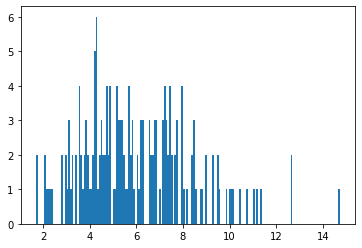

In [12]:
def get_durations_as_df(path="./Final Data m,e,s"):
    cols=['start_briefing', 'start_task', 'start_survey', 'end_survey']
    list_time = []
    for file in os.listdir(path):
        full_filename = "%s/%s" % (path, file)
        with open(full_filename,'r') as fi:
            dict = json.load(fi)
            start_briefing = 0
            start_task = 0
            start_survey = 0
            end_survey = 0
            for entry in dict["briefing"]:
                if entry["category"] == "briefingEvent" and entry["eventName"] == "displayBriefingStep":
                    start_briefing = entry["timeOfEvent"]
                    break
            for entry in dict["ranking"]:
                if entry["category"] == "serverEvent" and entry["eventName"] == "loadNewRankingType":
                    start_task = entry["timeOfEvent"]
                    break
            for entry in dict["survey"]:
                if entry["category"] == "serverEvent" and entry["eventName"] == "loadSurveyQuestion":
                    start_survey = entry["timeOfEvent"]
                    break
            for entry in dict["survey"]:
                if entry["category"] == "btn" and entry["eventName"] == "finishedTest":
                    end_survey = entry["timeOfEvent"]
                    break
            list_time.append([start_briefing, start_task, start_survey, end_survey])
    return pd.DataFrame(list_time,columns=cols)

#structured_analysis(until=20)
data = get_durations_as_df()
#print(data)
cols = ['briefing', 'task', 'survey','total']
all_list = []
for i in range(0, len(data.index)):
    time_list = []
    time_list.append(((data.iloc[i][1]-data.iloc[i][0])/1000)/60)
    time_list.append(((data.iloc[i][2]-data.iloc[i][1])/1000)/60)
    time_list.append(((data.iloc[i][3]-data.iloc[i][2])/1000)/60)
    time_list.append(((data.iloc[i][3]-data.iloc[i][0])/1000)/60)
    all_list.append(time_list)
df = pd.DataFrame(all_list, columns = cols)
print(df)
print(df["total"].mean())
print(df["total"].min())
print(df["total"].max())
times = []
for entry in df["total"]:
    times.append(entry)
    
times.sort(reverse=True)
times.remove(times[0])
times.remove(times[0])
print(sum(times)/len(times))
plt.hist(times, bins = len(times))
    

#print(df["task"].min())
#print(df["survey"].min())

0.590027700831025
0.407202216066482
['10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '10k29k', '120kandMore', '120kandMore', '120kandMore', '120kandMore', '120kandMore', '120kandMore', '120kandMore', '120kandMore', '120kandMore', '120kandMore', '120kandMore', '120kandMore', '120kandMore', '120kandMore', '120kandMore', '120kandMore', '120kandMore', '120kandMore', '120kandMore', '120kandMore', '120kandMore', '120kandMore', '120kandMore', '120kandMore', '120kandMore', '120kandMore', '12

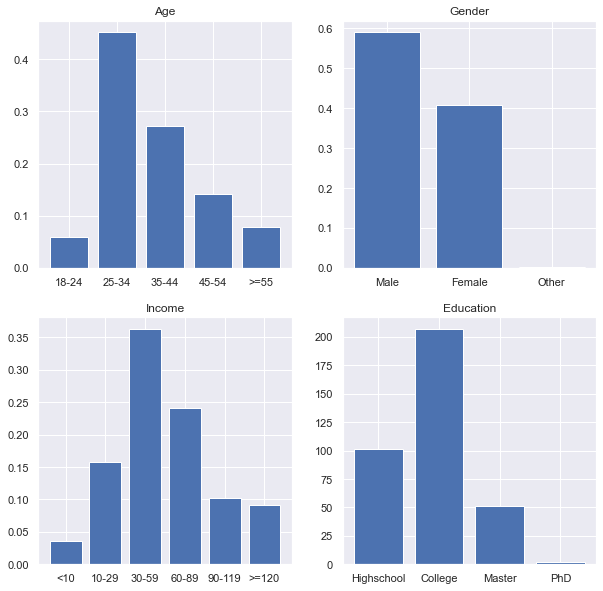

In [84]:
import pandas as pd
import numpy as np
import seaborn as sns

def bins_labels(bins, **kwargs):
    bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
    plt.xticks(np.arange(min(bins)+bin_w/2, max(bins), bin_w), bins, **kwargs)
    plt.xlim(bins[0], bins[-1])

data = load_data_as_df('./Final Data all')
demographics = []
for entry in data["survey_answers"]:
    for answer in entry:
        if "question" in answer and answer["question"] == 6 and len(answer["answers"])==4:
            demographics.append(answer["answers"])
genders = []
ages = []
educations = []
incomes = []
for entry in demographics:
    for i in range(0,len(entry)):
        answer = entry[i].split(' ')[0]
        if i == 0:
            genders.append(answer)
        if i == 1:
            ages.append(answer)
        if i == 2:
            educations.append(answer)
        if i == 3:
            incomes.append(answer)

males = 0
females = 0
others = 0
for entry in genders:
    if entry == 'male':
        males+=1
    if entry == 'female':
        females+=1
    else:
        others+=1
print(males/len(genders))
print(females/len(genders))
age1824 = []
age2534 = []
age3544 = []
age4554 = []
agege55 = []
ages_new=[]
for entry in ages:
    if entry == '1824':
        age1824.append(entry)
        ages_new.append('18-24')
    if entry == '2534':
        age2534.append(entry)
        ages_new.append('25-34')
    if entry == '3544':
        age3544.append(entry)
        ages_new.append('35-44')
    if entry == '4554':
        age4554.append(entry)
        ages_new.append('45-54')
    if entry == 'ge55':
        agege55.append(entry)
        ages_new.append('>=55')
ages_new.sort()

highschool = []
college = []
master = []
phd = []
for entry in educations:
    if entry == 'master':
        master.append(entry)
    if entry == 'college':
        college.append(entry)
    if entry == 'highschool':
        highschool.append(entry)
    if entry == 'PhD':
        phd.append(entry)
incomes.sort()
print(incomes)
less10k = 0
ten_29 = 0
thirty_59 = 0
sixty_89 = 0
ninty_119 = 0
ge120 = 0
for e in incomes:
    if e == 'less10k':
        less10k+=1
    if e == '10k29k':
        ten_29+=1
    if e == '30k59k':
        thirty_59+=1
    if e == '60k89k':
        sixty_89+=1
    if e == '90k119k':
        ninty_119+=1
    if e == '120kandMore':
        ge120+=1


fig, axs = plt.subplots(2, 2 , figsize=(10, 10))
axs[0, 0].bar(['18-24', '25-34', '35-44', '45-54', '>=55'], [len(age1824)/len(ages),len(age2534)/len(ages), len(age3544)/len(ages),len(age4554)/len(ages), len(agege55)/len(ages)])
axs[0, 0].set_title('Age')
axs[0, 1].bar(['Male', 'Female', 'Other'], [males/len(genders),females/len(genders),1/len(genders)])
axs[0, 1].set_title('Gender')
axs[1,1].bar(['Highschool', 'College', 'Master', 'PhD'], [len(highschool), len(college), len(master), len(phd)])
axs[1, 1].set_title('Education')
axs[1,0].bar(['<10', '10-29','30-59', '60-89', '90-119', '>=120'], [less10k/len(incomes), ten_29/len(incomes), thirty_59/len(incomes), sixty_89/len(incomes),ninty_119/len(incomes), ge120/len(incomes)])
axs[1, 0].set_title('Income')
plt.show()
#df['age'].value_counts().plot(kind='bar')